# Learn to run algorithms using Fire Opal

**Create and run Simon's algorithm with Fire Opal**

In this tutorial, you will create and run a quantum program with Fire Opal. In particular, you will implement Simon's algorithm to deduce a hidden bitstring from a black-box function. [Simon's algorithm](https://en.wikipedia.org/wiki/Simon%27s_problem) was the first quantum algorithm to show an exponential speedup compared to its classical counterpart.

For this tutorial, you'll need to install the Fire Opal Python package and other dependencies:

```shell
pip install fire-opal qiskit qiskit-ibm-runtime qiskit-aer qctrl-visualizer
```

By completing this tutorial, you will:

1. Define the quantum circuit.
1. Run the quantum circuit on real hardware and a simulator.
1. Compare the results.

### 1. Import packages and dependencies

In [26]:
import fireopal as fo
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import qctrlvisualizer
from qctrlvisualizer import QCTRL_STYLE_COLORS as colors

### 2. Define helper functions and the circuit
By running the cell below, you will define and visualize a quantum circuit for Simon's algorithm using the [OpenQASM](https://arxiv.org/abs/1707.03429) string representation. This representation is required by Fire Opal, and is typically obtained by exporting a quantum circuit written with one of the various quantum-specific Python packages. For example, Qiskit [has a tutorial](https://learn.qiskit.org/course/ch-algorithms/simons-algorithm#algorithm) to create this same circuit as a `QuantumCircuit` object. This object should then be exported to an OpenQASM string using the [`QuantumCircuit.qasm()`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.qasm.html) method.

In [76]:
def counts_to_probabilities(counts, shot_count):
    probabilites = {keystr: count / shot_count for keystr, count in counts.items()}
    return probabilites


def draw_circuit(qasm_str: str):
    """Draws a QASM circuit."""
    circuit = QuantumCircuit.from_qasm_str(qasm_str)
    print(circuit)


def plot_results(results, correct_strings, title, color=None):
    plt.style.use(qctrlvisualizer.get_qctrl_style())
    plt.figure()

    bars = plt.bar(results.keys(), results.values())
    for index, bitstring in enumerate(results.keys()):
        if bitstring not in correct_strings:
            bars[index].set_color("grey")
        elif color is not None:
            bars[index].set_color(color)

    plt.xticks(rotation=90)
    plt.ylabel("Probability")
    plt.xlabel("Bitstrings")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [3]:
simon_circuit_qasm = """OPENQASM 2.0;
include "qelib1.inc";

// Define two six-qubit quantum registers and one classical register.
qreg q[12];
creg c[6];

// Put the first register in superposition.
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];

// Build the Simon oracle for hidden bitstring '111110'. Begin by copying
// the first register to the second. Then, for each '1' in the hidden
// bitstring, apply XOR targeting the corresponding bit in the second
// register.
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11];
cx q[0],q[6];
cx q[1],q[7];
cx q[2],q[8];
cx q[3],q[9];
cx q[4],q[10];
cx q[5],q[11];
cx q[1],q[7];
cx q[1],q[8];
cx q[1],q[9];
cx q[1],q[10];
cx q[1],q[11];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11];

// Take the first register out of superposition.
h q[0];
h q[1];
h q[2];
h q[3];
h q[4];
h q[5];

// Measure the first register.
measure q[0] -> c[0];
measure q[1] -> c[1];
measure q[2] -> c[2];
measure q[3] -> c[3];
measure q[4] -> c[4];
measure q[5] -> c[5];
"""

draw_circuit(simon_circuit_qasm)

      ┌───┐ ░                                                         ░ ┌───┐»
 q_0: ┤ H ├─░───■─────────────────────────────────────────────────────░─┤ H ├»
      ├───┤ ░   │                                                     ░ ├───┤»
 q_1: ┤ H ├─░───┼────■────────────────────────■────■────■────■────■───░─┤ H ├»
      ├───┤ ░   │    │                        │    │    │    │    │   ░ ├───┤»
 q_2: ┤ H ├─░───┼────┼────■───────────────────┼────┼────┼────┼────┼───░─┤ H ├»
      ├───┤ ░   │    │    │                   │    │    │    │    │   ░ ├───┤»
 q_3: ┤ H ├─░───┼────┼────┼────■──────────────┼────┼────┼────┼────┼───░─┤ H ├»
      ├───┤ ░   │    │    │    │              │    │    │    │    │   ░ ├───┤»
 q_4: ┤ H ├─░───┼────┼────┼────┼────■─────────┼────┼────┼────┼────┼───░─┤ H ├»
      ├───┤ ░   │    │    │    │    │         │    │    │    │    │   ░ ├───┤»
 q_5: ┤ H ├─░───┼────┼────┼────┼────┼────■────┼────┼────┼────┼────┼───░─┤ H ├»
      └───┘ ░ ┌─┴─┐  │    │    │    │    │    │    │

Note that the circuit above is specific to the hidden bitstring `110`. Also notice that you are measuring the top three qubits to obtain a bitstring at the end of the circuit. This measurement will be important for determining the hidden bitstring after you run the quantum program.

### 3. Set up your credentials and backend
You can either use IBM's publicly-available quantum computers to run this circuit, you can use a private provider. To do so, you will need a personal token for IBM's quantum computing API. Visit [IBM Quantum](https://quantum-computing.ibm.com/) to obtain your token or sign up for an account.

In [4]:
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_TOKEN_HERE"
credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

instance = hub + "/" + group + "/" + project
service = QiskitRuntimeService(token=token, instance=instance, channel="ibm_quantum")

Choose a backend from those to which your provider has access. You can check your accessible devices through your [IBM Quantum account](https://quantum-computing.ibm.com/).

In [5]:
# Enter your desired IBM backend here.
backend_name = "BACKEND_NAME_HERE"

### 4. Validate the circuit
Prior to submitting your circuit for execution, use `validate` to ensure that it is free of syntax errors and compatible with Fire Opal's requirements.

Note that upon running a function from Fire Opal for the first time, your default web browser will open and you will be able to enter your Fire Opal credentials. Once authenticated, the browser will display a success message and you may close the tab.

In [ ]:
circuit_errors = fo.validate(
    circuits=[simon_circuit_qasm], credentials=credentials, backend_name=backend_name
)

In [7]:
print(f"Number of circuit errors found: {len(circuit_errors['results'])}")

Number of circuit errors found: 0


### 5. Run the circuit with Fire Opal
Now that you know the circuit is error-free, you can run it using `execute` by providing the OpenQASM representation of your circuit and your credentials as shown below. Fire Opal will compile, optimize, and make the circuit robust against noise before execution.

Note that this cell might take awhile to run, depending on the level of activity on IBM's devices. Visit [IBM's jobs page](https://quantum-computing.ibm.com/jobs) to track the status of your circuit.

In [ ]:
shot_count = 1024

fire_opal_job = fo.execute(
    circuits=[simon_circuit_qasm],
    shot_count=shot_count,
    credentials=credentials,
    backend_name=backend_name,
)

In [ ]:
fire_opal_bitstring_results = fire_opal_job.result()["results"][0]

#### 5.1. Run the circuit without Fire Opal
For comparison, you can run the circuit on IBM hardware without using Fire Opal.

In [ ]:
backend = service.backend(backend_name, instance=instance)
circuit_qiskit = QuantumCircuit.from_qasm_str(simon_circuit_qasm)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit_qiskit)

sampler = Sampler(backend)
result = sampler.run([isa_circuit], shots=shot_count).result()
ibm_counts = result[0].data.c.get_counts()

Congratulations! You've successfully run a quantum circuit on real hardware. In the next section, you'll visualize your results and compare them to an ideal case.

### 6. Plot and intepret results
Here you'll get the measured bitstrings from your results and plot their relative frequency. We can compare the results to the simulated distribution which is very close to the ideal solution.

To get a sense of what the distribution should look like in the absence of hardware noise, you can run the same circuit using a simulator. Quantum simulators, which use regular classical computation to simulate the dynamics of a quantum computer, are useful for prototyping and checking algorithm correctness on small quantum circuits.

In [28]:
simulator_shot_count = 40000
circuit_qiskit = QuantumCircuit.from_qasm_str(simon_circuit_qasm)
aer_simulator = AerSimulator(method="statevector")
job = aer_simulator.run(circuit_qiskit, shots=simulator_shot_count)
ideal_simulator_counts = job.result().get_counts()

ideal_counts = {f"{n:06b}": 0 for n in range(64)}
ideal_counts.update(ideal_simulator_counts)
ideal_probabilities = counts_to_probabilities(
    counts=ideal_counts, shot_count=simulator_shot_count
)

Now, the results from the execution with Fire Opal are shown, followed by the results without Fire Opal, and then the ideal distribution.

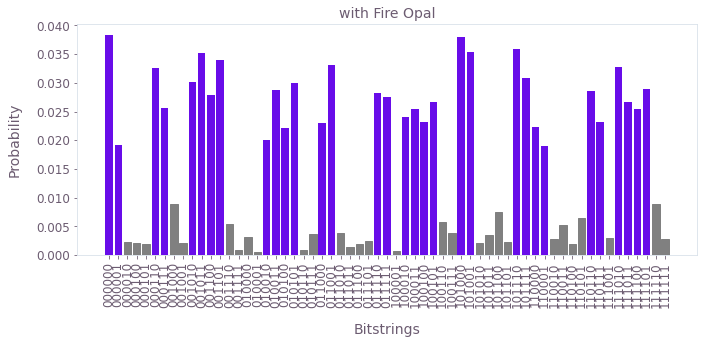

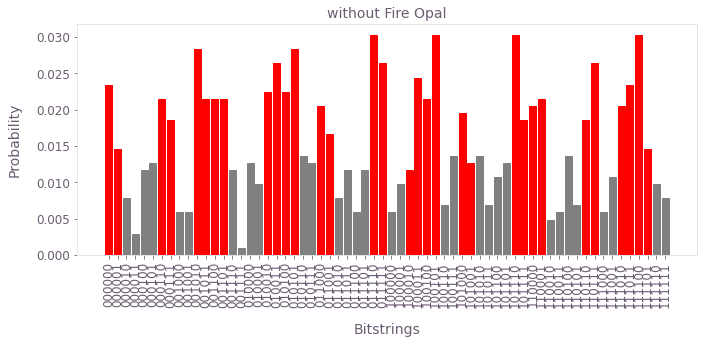

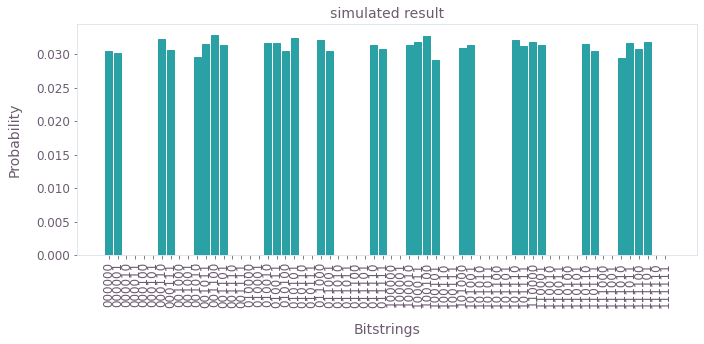

In [77]:
correct_bitstrings = {
    bitstring for bitstring in ideal_probabilities if ideal_probabilities[bitstring] > 0
}
plot_results(fire_opal_bitstring_results, correct_bitstrings, title="with Fire Opal")
plot_results(ibm_counts, correct_bitstrings, title="without Fire Opal", color=colors[1])
plot_results(
    ideal_probabilities, correct_bitstrings, title="simulated result", color=colors[2]
)

In the absence of hardware noise, the result from Simon's Algorithm (let's call it $z$) with the hidden bitstring $b$ always satisfies $ b \cdot z = 0 \; (\textrm{mod} \;2)$. See the [Qiskit textbook](https://learn.qiskit.org/course/ch-algorithms/simons-algorithm#problem) for details. 

Notice from your histogram that the correct choices for $z$ are indeed the most likely results from running your circuit on Fire Opal, and the results obtained using Fire Opal are closer to those measured without. However, due to hardware noise, some erroneous bitstrings are bound occur. In the next section, you can quantify the accuracy of each run by checking the probability that a random selection of one of your results would be incorrect.

### 7. Calculate and compare error probability
The following helper functions check the probability of getting the wrong result from each of the previously generated distributions.

In [12]:
def dot_mod2(b: str, z: str) -> int:
    """Calculates the dot product between bitstrings `b` and `z`, modulus 2."""
    total = 0

    for i in range(len(b)):
        total += int(b[i]) * int(z[i])

    return total % 2


def error_probability(bitstring_results: dict[str, float], b: int) -> float:
    """
    Returns the chance that if we took a single sample from our results
    that we would get a sample that would mislead us into reconstructing a wrong `b`.
    """
    failure_probability = 0

    for bitstring, probability in bitstring_results.items():
        is_failure = dot_mod2(b, bitstring)
        failure_probability += is_failure * probability

        print(
            f'{probability}{"✅❌"[is_failure]}  {b}.{bitstring} = {is_failure} (mod 2)'
        )

    return failure_probability

First, check Fire Opal's distribution for the probability of inaccuracy.

In [13]:
b = "111110"
print("b = " + b)
print()
print("Fire Opal result:")
print(
    f"  Probability of sampling an incorrect z: {error_probability(fire_opal_bitstring_results, b):.1%}"
)

b = 111110

Fire Opal result:
0.0383254621558955✅  111110.000000 = 0 (mod 2)
0.019106735836278425✅  111110.000001 = 0 (mod 2)
0.002199935144117896❌  111110.000010 = 1 (mod 2)
0.002017166398263622❌  111110.000100 = 1 (mod 2)
0.0019413070488360491❌  111110.000101 = 1 (mod 2)
0.03266546950107776✅  111110.000110 = 0 (mod 2)
0.025540241532484693✅  111110.000111 = 0 (mod 2)
0.00886565785542177❌  111110.001000 = 1 (mod 2)
0.0021328730949892703❌  111110.001001 = 1 (mod 2)
0.030117694992249013✅  111110.001010 = 0 (mod 2)
0.03512243916383986✅  111110.001011 = 0 (mod 2)
0.027835670500373857✅  111110.001100 = 0 (mod 2)
0.03402188161213933✅  111110.001101 = 0 (mod 2)
0.005428288965677899❌  111110.001110 = 1 (mod 2)
0.0009235169845176978❌  111110.001111 = 1 (mod 2)
0.0031690758989380333❌  111110.010000 = 1 (mod 2)
0.0005617158987750632❌  111110.010001 = 1 (mod 2)
0.019962260470681118✅  111110.010010 = 0 (mod 2)
0.028807083094362702✅  111110.010011 = 0 (mod 2)
0.022078303641191458✅  111110.010100 = 0

Next, perform the same check with the results generated without Fire Opal.

In [14]:
ibm_probabilities = counts_to_probabilities(counts=ibm_counts, shot_count=shot_count)

b = "111110"
print("b = " + b)
print()
print("IBM result:")
print(
    f"  Probability of sampling an incorrect z: {error_probability(ibm_probabilities, b):.1%}"
)

b = 111110

IBM result:
0.013671875❌  111110.110100 = 1 (mod 2)
0.0283203125✅  111110.001010 = 0 (mod 2)
0.0302734375✅  111110.011110 = 0 (mod 2)
0.0048828125❌  111110.110010 = 1 (mod 2)
0.0263671875✅  111110.011111 = 0 (mod 2)
0.0126953125❌  111110.000101 = 1 (mod 2)
0.009765625❌  111110.111110 = 1 (mod 2)
0.01171875❌  111110.011011 = 1 (mod 2)
0.01171875✅  111110.100010 = 0 (mod 2)
0.0234375✅  111110.000000 = 0 (mod 2)
0.0302734375✅  111110.111100 = 0 (mod 2)
0.0205078125✅  111110.111010 = 0 (mod 2)
0.021484375✅  111110.001100 = 0 (mod 2)
0.0205078125✅  111110.110000 = 0 (mod 2)
0.0244140625✅  111110.100011 = 0 (mod 2)
0.0302734375✅  111110.101110 = 0 (mod 2)
0.013671875❌  111110.010110 = 1 (mod 2)
0.0107421875❌  111110.111001 = 1 (mod 2)
0.0234375✅  111110.111011 = 0 (mod 2)
0.0205078125✅  111110.011000 = 0 (mod 2)
0.0224609375✅  111110.010010 = 0 (mod 2)
0.021484375✅  111110.001101 = 0 (mod 2)
0.0078125❌  111110.111111 = 1 (mod 2)
0.0224609375✅  111110.010100 = 0 (mod 2)
0.02148437

The probability of getting an incorrect result without Fire Opal is more than double the chances with Fire Opal!

As a quick check, you can also compare the results of the ideal simulator. If there was no hardware noise at all, the probability of obtaining an incorrect output should be 0%. 

In [15]:
b = "111110"
print("b = " + b)
print()
print("Ideal simulator result:")
print(
    f"  Probability of sampling an incorrect z: {error_probability(ideal_probabilities, b):.1%}"
)

b = 111110

Ideal simulator result:
1.19140625✅  111110.000000 = 0 (mod 2)
1.2353515625✅  111110.000001 = 0 (mod 2)
0.0❌  111110.000010 = 1 (mod 2)
0.0❌  111110.000011 = 1 (mod 2)
0.0❌  111110.000100 = 1 (mod 2)
0.0❌  111110.000101 = 1 (mod 2)
1.263671875✅  111110.000110 = 0 (mod 2)
1.2587890625✅  111110.000111 = 0 (mod 2)
0.0❌  111110.001000 = 1 (mod 2)
0.0❌  111110.001001 = 1 (mod 2)
1.220703125✅  111110.001010 = 0 (mod 2)
1.2138671875✅  111110.001011 = 0 (mod 2)
1.16015625✅  111110.001100 = 0 (mod 2)
1.1865234375✅  111110.001101 = 0 (mod 2)
0.0❌  111110.001110 = 1 (mod 2)
0.0❌  111110.001111 = 1 (mod 2)
0.0❌  111110.010000 = 1 (mod 2)
0.0❌  111110.010001 = 1 (mod 2)
1.1943359375✅  111110.010010 = 0 (mod 2)
1.2509765625✅  111110.010011 = 0 (mod 2)
1.21484375✅  111110.010100 = 0 (mod 2)
1.166015625✅  111110.010101 = 0 (mod 2)
0.0❌  111110.010110 = 1 (mod 2)
0.0❌  111110.010111 = 1 (mod 2)
1.2470703125✅  111110.011000 = 0 (mod 2)
1.302734375✅  111110.011001 = 0 (mod 2)
0.0❌  111110.011

As expected, in the absence of hardware noise there is zero probability of the algorithm producing an erroneous output.

### 8. Conclusions
Congratulations! You've now run Simon's algorithm and seen the benefits of Fire Opal. By suppressing hardware noise, Fire Opal gets much closer to the ideal distribution and lowers the likelihood of obtaining incorrect measurements. This is even more crucial when running deeper and more complex circuits.

The quantum control technology can be applied across various algorithms. Next, try using Fire Opal's QAOA solver by running the tutorial [Solving MaxCut using Fire Opal](https://docs.q-ctrl.com/fire-opal/apply/solve-max-cut-using-fire-opal).

The package versions below were used to produce this notebook.

In [16]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.11.8  |
| matplotlib            | 3.8.4   |
| networkx              | 2.8.8   |
| numpy                 | 1.26.4  |
| qiskit                | 1.0.2   |
| qiskit-ibm-provider   | 0.11.0  |
| qiskit-ibm-runtime    | 0.23.0  |
| sympy                 | 1.12    |
| fire-opal             | 7.3.1   |
| qctrl-visualizer      | 7.1.0   |
| qctrl-workflow-client | 3.0.0   |
